# EDA

In [5]:
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import lightgbm as lgb

with open("efficientnetb0_gap_features.pkl", "rb") as f:
    data = pickle.load(f)

X = np.array(data['features'])
y = np.array(data['labels'])
image_names = np.array(data['image_names'])

le = LabelEncoder()
y_encoded = le.fit_transform(y)

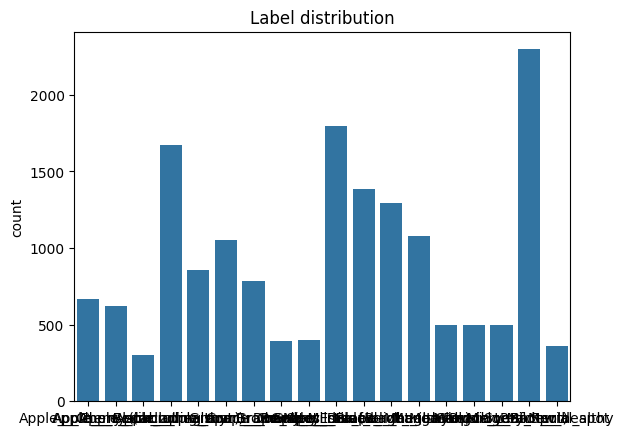

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=y)
plt.title("Label distribution")
plt.show()

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

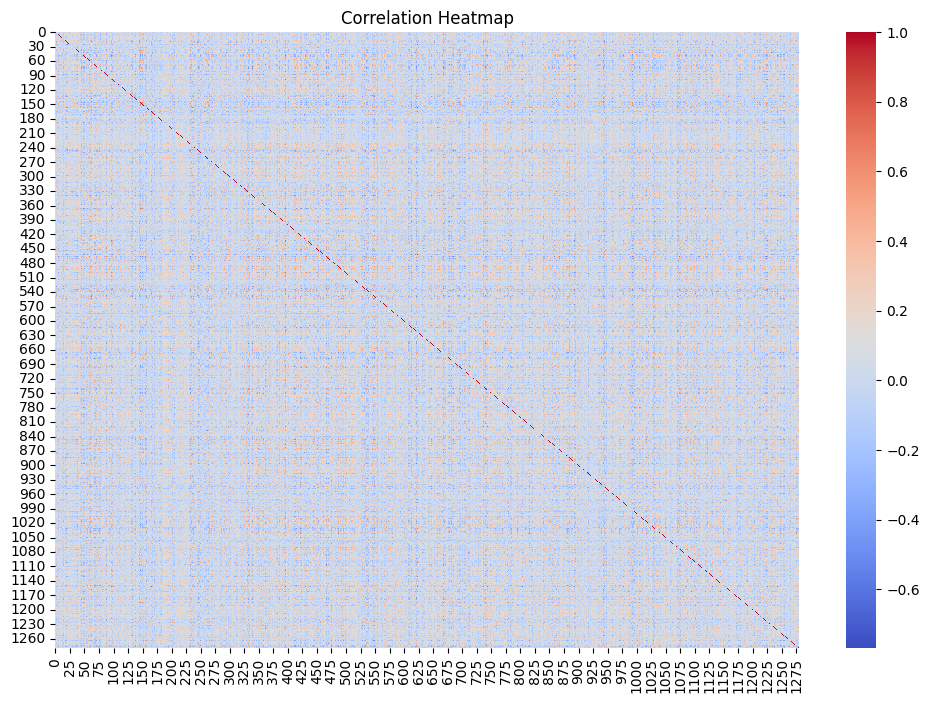

In [8]:
X_scaled_df = pd.DataFrame(X_scaled)

corr = X_scaled_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

In [9]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_scaled)
eigenvalues = pca.explained_variance_
import numpy as np

count_ge_1 = np.sum(eigenvalues >= 1)
total_components = len(eigenvalues)
percentage = 100 * count_ge_1 / total_components

print(f"Số lượng eigenvalue >= 1: {count_ge_1}/{total_components}")
print(f"Tỷ lệ phần trăm: {percentage:.2f}%")


Số lượng eigenvalue >= 1: 165/1280
Tỷ lệ phần trăm: 12.89%


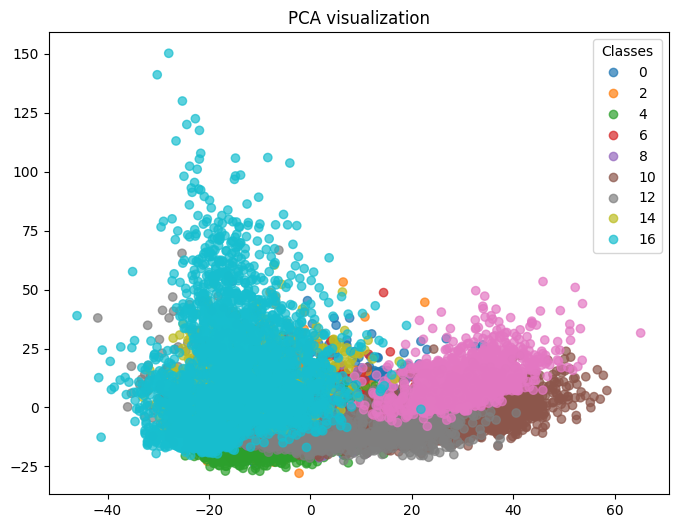

In [4]:
import matplotlib.pyplot as plt
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=y_encoded, cmap='tab10', alpha=0.7)
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title("PCA visualization")
plt.show()


# Features Selection

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=165)
X_pca = pca.fit_transform(X_scaled)
print("Kích thước ban đầu:", X_scaled.shape)
print("Kích thước sau PCA:", X_pca.shape)

Kích thước ban đầu: (16446, 1280)
Kích thước sau PCA: (16446, 165)


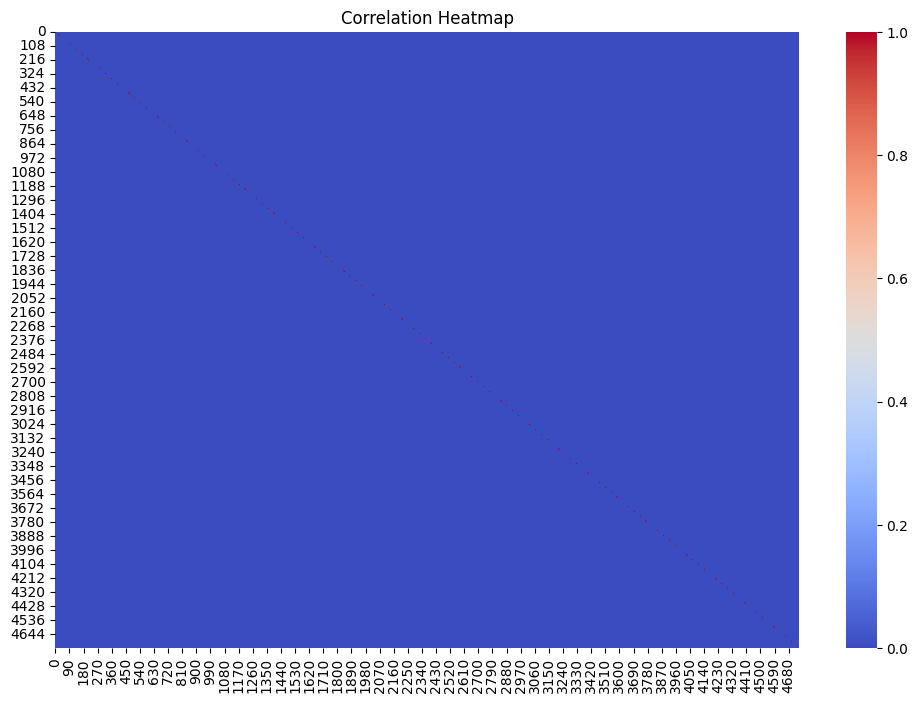

In [13]:
X_pca_df = pd.DataFrame(X_pca)

corr = X_pca_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Training

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, random_state=42),
    "SVM": SVC(kernel='rbf', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=89, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=75, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=8),
    "LightGBM": lgb.LGBMClassifier(n_estimators=88, random_state=42, verbose=-1)
}

all_results = []

for name, model in models.items():
    print(f"Training {name}...")

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    cv_scores = cross_val_score(model, X_scaled, y_encoded, cv=5, scoring='accuracy')

    all_results.append({
        "Model": name,
        "Accuracy": round(accuracy, 4),
        "Precision": round(precision, 4),
        "Recall": round(recall, 4),
        "F1 Score": round(f1, 4),
        "CV_scores(5fold)": round(np.mean(cv_scores), 4)
    })

df_results = pd.DataFrame(all_results)
df_results.to_csv("model_results_PCA_EfficientNet.csv", index=False)
print("Đã lưu kết quả vào 'model_results.csv'")

Training Logistic Regression...
Training SVM...
Training Random Forest...
Training Gradient Boosting...
